# Исследование данных об использовании сервиса с применением когортного анализа

**Заказчик:** отдел маркетинговой аналитики.

**Входные данные:** данные с начала июня 2017 года по конец мая 2018 года:
- лог сервера с данными о посещениях сайта,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

**Цель проекта:** помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

**Задачи проекта:**

- оценить качество предоставленных данных;
- провести подготовку данных к анализу: при необходимости исправить ошибки, проанализировать и заполнить пропуски, добавить расчетные поля, представить данные в удобной для анализа форме;
- выснить, рассчитав соответствующие метрики:
    - как клиенты пользуются сервисом;
    - когда делают первые покупки на сайте;
    - сколько денег приносит компании каждый клиент;
    - когда расходы на привлечение клиента окупаются.
- дать рекомендации заказчику по результатам исследования;
- определить потенциальные риски данного исследования, возможности их устранения;  
- дать рекомендации по дальнейшему развитию данного исследования.

*В качестве денежной единицы используется у.е.*

---
## Начальная подготовка

### Подготовка среды

In [299]:
import pandas as pd
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [300]:
# загрузка данных

def df_read_csv(path, sep=','):
    
    try:
        return pd.read_csv(path, sep)
    except Exception:
        print('Ошибка при загрузке файла')


#--------------------------------------------------------------------
# определение имени таблицы

def df_name(df):
    
    return [name for name in globals() if globals()[name] is df][0]


#--------------------------------------------------------------------
# первичная информация о таблице

def basic_info(df, sample='sample', qnty=10):

    print(f'\n{f.BOLD}таблица {df_name(df)}{f.END} {theme_char*20}\n\n')

    # метод info()
    print(df.info())

    # несколько записей
    if sample == 'sample':
        display(df.sample(qnty))
    elif sample == 'head':
        display(df.head(qnty))
    elif sample == 'tail':
        display(df.tail(qnty))
    
    # метод describe()
    print(df.describe(), '\n')
    print(df.describe(exclude=['int', 'int64', 'uint', 'uint64', 'float', 'float64']), '\n')


#--------------------------------------------------------------------
# перевод значений полей типа object в нижний регистр

def object_fields_lower(df):  # dataframe
    
    for i in range(len(df.dtypes)):
        if df.dtypes[i] == 'object':
            df[df.columns[i]] = df[df.columns[i]].str.lower()


#--------------------------------------------------------------------
# проверка на дубликаты

def duplicated_test(df):
    print('\n',
          f'количество полных дубликатов в таблице {f.BOLD + df_name(df) + f.END}: {df.duplicated().sum()}',
          '\n')


#--------------------------------------------------------------------
# числовые значения для вертикальных bar-графиков
# доработать до универсальной (+ горизонтальные)

def bar_annotate(ax, decimals=0):
    
    max_height = 0
    for p in ax.patches:
        if p.get_height() > max_height:
            max_height = p.get_height()
    
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + max_height*0.01
        value = f'{p.get_height():.{decimals}f}'
        ax.text(_x, _y, value, ha="center")

In [301]:
# ДЛЯ ОФОРМЛЕНИЯ

#--------------------------------------------------------------------------
# для свободного пространства (пустые строки)

def space(num=1):
    print('\n' * num)
    
#--------------------------------------------------------------------------
# для украшения и разнообразия: ∻ ⋰ ≋

theme_char = '≋'

#--------------------------------------------------------------------------
# для оформления текста
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

### Настройки

In [302]:
# стиль графиков
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plot_dpi = 150              # dpi для рендеринга графиков

# цвета для графиков
colors = ['darkcyan', 'orange', 'tomato']

# внешний вид
warnings.filterwarnings('ignore')
# pd.set_option('display.precision', 7)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 100)

### Загрузка данных

In [303]:
# входные данные
visits = pd.read_csv('datasets/visits_log.csv')
orders = pd.read_csv('datasets/orders_log.csv')
costs = pd.read_csv('datasets/costs.csv')

---
## Общая информация о входных данных

### Базовая проверка: info(), describe(), визуально

In [304]:
def basic_info(df, sample, qnty=10):

    print(font.BOLD + '\n'*2 + f'таблица {df_name(df)}' + font.END + '   ' + line_end(15) + '\n')
    print(df.info())
    if sample == 'sample':
        display(df.sample(qnty))
    elif sample == 'head':
        display(df.head(qnty))
    else:
        display(df.tail(qnty))
    print(df.describe(), '\n')
    print(df.describe(exclude=['int', 'uint', 'float']))

In [305]:
basic_info(visits, 'sample', 5)
basic_info(orders, 'sample', 5)
basic_info(costs, 'sample', 5)



таблица visits   ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


,Device,End Ts,Source Id,Start Ts,Uid
215588,desktop,2017-07-17 13:12:00,3,2017-07-17 13:11:00,998490360786393372
138449,touch,2018-02-07 14:04:00,5,2018-02-07 14:01:00,4070412219312530827
359109,desktop,2017-08-15 00:58:19,5,2017-08-15 00:58:00,12428542403453747463
175054,touch,2017-07-03 12:50:00,4,2017-07-03 12:25:00,1886270465577825906
250941,desktop,2017-12-19 20:32:00,3,2017-12-19 20:30:00,7435753469457128366


       Source Id                     Uid
count  359400.00               359400.00
mean        3.75  9202556994354921472.00
std         1.92  5298432824659611648.00
min         1.00       11863502262781.00
25%         3.00  4613406732167550976.00
50%         4.00  9227412908740601856.00
75%         5.00 13728237011236171776.00
max        10.00 18446676030785673216.00 

         Device               End Ts  Source Id             Start Ts  \
count    359400               359400  359400.00               359400   
unique        2               224760        nan               224303   
top     desktop  2017-11-24 16:51:00        nan  2017-11-24 16:06:00   
freq     262567                   23        nan                   19   
mean        NaN                  NaN       3.75                  NaN   
std         NaN                  NaN       1.92                  NaN   
min         NaN                  NaN       1.00                  NaN   
25%         NaN                  NaN       3.00      

,Buy Ts,Revenue,Uid
14553,2017-10-25 16:51:00,19.55,9297273867711183973
18391,2017-11-19 14:46:00,3.05,2085794068914755090
33451,2018-02-07 18:56:00,1.17,16144887554038225556
12957,2017-10-15 23:09:00,73.33,9502403559613700472
12556,2017-10-13 13:58:00,6.11,10888247059713734605


       Revenue                     Uid
count 50415.00                50415.00
mean      5.00  9098160634289729536.00
std      21.82  5285741550834715648.00
min       0.00      313578113262317.00
25%       1.22  4533566627250599936.00
50%       2.50  9102273602618561536.00
75%       4.89 13682901980465401856.00
max    2633.28 18446167067214817280.00 

                     Buy Ts                     Uid
count                 50415                50415.00
unique                45991                     nan
top     2018-05-31 10:13:00                     nan
freq                      9                     nan
mean                    NaN  9098160634289729536.00
std                     NaN  5285741550834715648.00
min                     NaN      313578113262317.00
25%                     NaN  4533566627250599936.00
50%                     NaN  9102273602618561536.00
75%                     NaN 13682901980465401856.00
max                     NaN 18446167067214817280.00


таблица costs   ≋≋≋≋≋

,source_id,dt,costs
935,3,2017-12-27,279.55
1970,9,2017-11-02,26.58
1544,5,2017-09-01,119.64
792,3,2017-08-06,116.50
1334,4,2018-02-01,10.46


       source_id   costs
count    2542.00 2542.00
mean        4.86  129.48
std         3.18  156.30
min         1.00    0.54
25%         2.00   21.95
50%         4.00   77.30
75%         9.00  170.06
max        10.00 1788.28 

        source_id          dt
count     2542.00        2542
unique        nan         364
top           nan  2017-12-10
freq          nan           7
mean         4.86         NaN
std          3.18         NaN
min          1.00         NaN
25%          2.00         NaN
50%          4.00         NaN
75%          9.00         NaN
max         10.00         NaN


### Начальная подготовка данных

In [306]:
# переименование полей
visits.columns = ['device', 'ts_end', 'id_source', 'ts_start', 'id_user']
orders.columns = ['ts_order', 'revenue', 'id_user']
costs.columns = ['id_source', 'date', 'costs']

# корректировка типов данных
visits[['ts_end', 'ts_start']] = visits[['ts_end', 'ts_start']].astype('datetime64')
orders['ts_order'] = orders['ts_order'].astype('datetime64')
costs['date'] = costs['date'].astype('datetime64')

display(visits.dtypes)
display(orders.dtypes)
display(costs.dtypes)

device               object
ts_end       datetime64[ns]
id_source             int64
ts_start     datetime64[ns]
id_user              uint64
dtype: object

ts_order    datetime64[ns]
revenue            float64
id_user             uint64
dtype: object

id_source             int64
date         datetime64[ns]
costs               float64
dtype: object

### Проверка на дубликаты

In [307]:
duplicated_test(visits)
duplicated_test(orders)
duplicated_test(costs)


 количество полных дубликатов в таблице visits: 0 


 количество полных дубликатов в таблице orders: 0 


 количество полных дубликатов в таблице costs: 0 



In [308]:
# проверка по сокращенному количеству (основных) полей

visits_cuted = visits[['id_user', 'ts_start']]
orders_cuted = orders[['id_user', 'ts_order']]
costs_cuted = costs[['id_source', 'date']]

duplicated_test(visits_cuted)
duplicated_test(orders_cuted)
duplicated_test(costs_cuted)


 количество полных дубликатов в таблице visits_cuted: 1 


 количество полных дубликатов в таблице orders_cuted: 0 


 количество полных дубликатов в таблице costs_cuted: 0 



In [309]:
# просмотр и удаление дубликатов

id_user_duplicated = visits_cuted[visits_cuted.duplicated()]['id_user'].tolist()

print('записи в таблице VISITS, которые, вероятно, являются дубликатами:')
display(visits.query('id_user in @id_user_duplicated'))

записи в таблице VISITS, которые, вероятно, являются дубликатами:


,device,ts_end,id_source,ts_start,id_user
44993,touch,2018-03-16 08:57:00,1,2018-03-16 08:55:00,1981020429381477763
47067,touch,2018-03-16 08:55:00,1,2018-03-16 08:55:00,1981020429381477763


Найденные записи не будем считать дубликатами, учитывая, что время сессий указано без использования секунд.

### Другие проверки

In [310]:
# покупки с нулевой суммой

print('количество покупок с нулевой суммой: {}'
      .format(orders.query("revenue==0")['revenue'].count()))

количество покупок с нулевой суммой: 51


In [311]:
# сессии с "нулевой" длительностью (на самом деле, не нулевой, т.к. точность указана до 1 минуты, секунды не используются)

print(
      'количество очень коротких сессий (менее 1 минуты):',
      len(visits.query('ts_start == ts_end'))
     )

количество очень коротких сессий (менее 1 минуты): 35794


In [312]:
# проверка совпадения временнЫх диапазонов в анализируемых таблицах

print(visits.ts_start.max())
print(orders.ts_order.max())
print(costs.date.max())

display(orders.query('ts_order > "2018-06-01"'))

# удаление записи о покупке, вышедшей за пределы анализируемого временного диапазона
orders = orders.drop(index=[50414])

2018-05-31 23:59:00
2018-06-01 00:02:00
2018-05-31 00:00:00


,ts_order,revenue,id_user
50414,2018-06-01 00:02:00,3.42,83872787173869366


### Вывод

**Временной интервал**

Совпадает для всех входных таблиц с данными.

Поскольку при указании времени в данных не используются секунды, фактическая точность  указания времени -- 1 минута.

**Типы данных**

Все поля, содержащие дату-время, преобразованы к типу **datetime**.

**Дубликаты**

Полностью одинаковых записей во входных данных не обнаружено.

**Другое**

В таблице **orders** обнаружена запись с датой покупки вне анализируемого диапазона. Это не ошибка данных, т.к. начало сессии находится в анализируемом диапазоне. С другой стороны, при выгрузке эта запись не должна была попасть во входные данные. Информацию следует передать {в технический отдел} для анализа причины.  
Лишняя запись удалена.

Найдена 51 запись, у которых сумма покупки равна нулю. Это могут быть как покупки "по акции", так и следствие технической ошибки. Необходимо выяснить в соответсвующем отделе, могли ли быть покупки с нулевой суммой. Ввиду их небольшого количества пока удалять не будем до выяснения причины их происхождения.

---
## Продуктовые метрики

### DAU, WAU и MAU

In [313]:
# расчет 

visits['year'] = visits['ts_start'].dt.year
visits['month'] = visits['ts_start'].dt.month
visits['week'] = visits['ts_start'].dt.week
visits['date'] = visits['ts_start'].dt.date.astype('datetime64')
visits['date_short'] = visits['date'].dt.strftime('%Y-%m')

DAU = visits.groupby('date')['id_user'].nunique()
WAU = visits.groupby(['year','week'])['id_user'].nunique()
MAU = visits.groupby(['year','month'])['id_user'].nunique()

line(30)
print('за весь исследуемый период:' + '\n')
print('  DAU =', int(DAU.mean()))
print('  WAU =', int(WAU.mean()))
print('  MAU =', int(MAU.mean()))
line(30)


≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋

за весь исследуемый период:

  DAU = 907
  WAU = 5716
  MAU = 23228

≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋



In [314]:
# преобразование для более привычного представления дат по оси Х (немного красоты)

MAU = MAU.reset_index()
MAU['date'] = MAU['year'].astype(str) + '-' + MAU['month'].astype(str)
MAU['date'] = pd.to_datetime(MAU['date']).dt.strftime('%Y-%m')

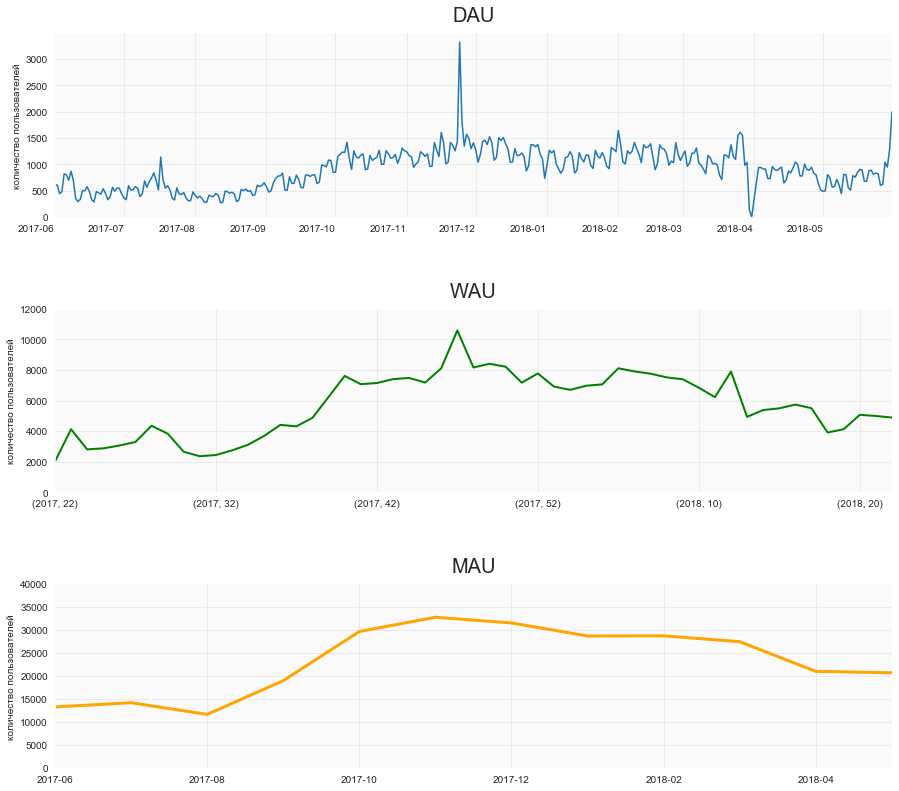

In [315]:
# графики

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,15))
fig.subplots_adjust(wspace=0, hspace=0.5)

DAU.plot(ax=axes[0], rot=0)
axes[0].set_title('DAU', fontsize=20, pad=12)
axes[0].set_ylabel('количество пользователей')
axes[0].set_xlabel('')
axes[0].set_ylim(0, )

WAU.plot(ax=axes[1], linewidth=2, color='green')
axes[1].set_title('WAU', fontsize=20, pad=12)
axes[1].set_ylabel('количество пользователей')
axes[1].set_xlabel('')
axes[1].set_ylim(0, 12000)

MAU.plot(ax=axes[2], x='date', y='id_user', linewidth=3, color='orange', legend=False)
axes[2].set_title('MAU', fontsize=20, pad=12)
axes[2].set_ylabel('количество пользователей')
axes[2].set_xlabel('')
axes[2].set_ylim(0, 40000)

space()
plt.show()
space()

### Сколько раз в среднем пользователи заходят на сайт?

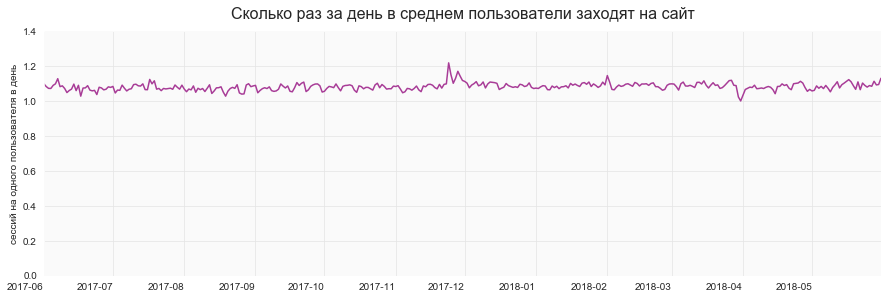

пользователи посещают сайт в среднем 1.08 раза в день





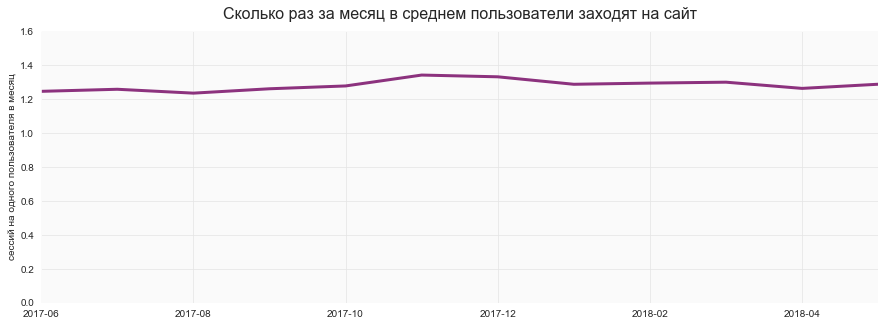

пользователи посещают сайт в среднем 1.28 раза в месяц




In [316]:
# в день

daily_visits = visits.groupby(['date']).agg({'id_user':['count', 'nunique']})
daily_visits.columns = ['sessions', 'users']
daily_visits['sessions_per_user'] = daily_visits['sessions'] / daily_visits['users']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
daily_visits['sessions_per_user'].plot(ax=axes, color='#a83c97', rot=0)
axes.set_title('Сколько раз за день в среднем пользователи заходят на сайт', fontsize=16, pad=12)
axes.set_ylabel('сессий на одного пользователя в день')
axes.set_xlabel('')
axes.set_ylim(0, 1.4)

space()
plt.show()

print(
      font.BOLD +
      'пользователи посещают сайт в среднем {:.2f} раза в день'
      .format(daily_visits['sessions_per_user'].mean()) +
      font.END
     )
line(0)


# в месяц

daily_visits = visits.groupby(['date_short']).agg({'id_user':['count', 'nunique']})
daily_visits.columns = ['sessions', 'users']
daily_visits['sessions_per_user'] = daily_visits['sessions'] / daily_visits['users']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
daily_visits['sessions_per_user'].plot(ax=axes, color='#8c327e', rot=0, linewidth=3)
axes.set_title('Сколько раз за месяц в среднем пользователи заходят на сайт', fontsize=16, pad=12)
axes.set_ylabel('сессий на одного пользователя в месяц')
axes.set_xlabel('')
axes.set_ylim(0, 1.6)

plt.show()

print(
      font.BOLD +
      'пользователи посещают сайт в среднем {:.2f} раза в месяц'
      .format(daily_visits['sessions_per_user'].mean()) +
      font.END
     )
space()

### Сколько времени пользователи проводят на сайте?

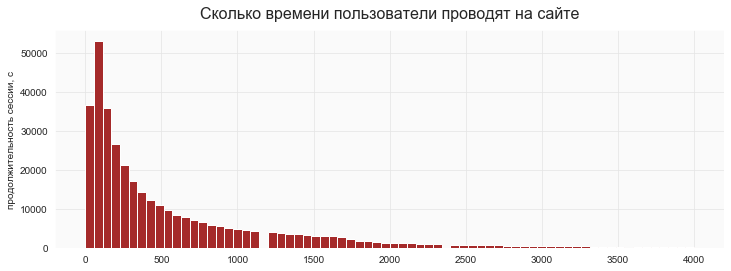

наиболее типичная продолжительность сессии, с: 60


In [317]:
visits['session_duration'] = (
                              (visits['ts_end'] - visits['ts_start']) / np.timedelta64(1,'s')
                             ).round().astype('Int64')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
visits['session_duration'].hist(bins=70, range=[0,4000], color='brown')
axes.set_title('Сколько времени пользователи проводят на сайте', fontsize=16, pad=12)
axes.set_ylabel('продолжительность сессии, с')
axes.set_xlabel('')

space()
plt.show()

print(
      font.BOLD +
      'наиболее типичная продолжительность сессии, с: {}'
      .format(int(visits.session_duration.mode())) +
      font.END
     )

> На гистограмме видны "выпадения" кратные примерно 1200 секундам: 1200, 2400, 3600. Это повод для отдельного исследования.

### Retention Rate

In [318]:
# первое посещение сайта

first_visit = visits.groupby('id_user')['ts_start'].min()
first_visit.name='first_visit'
visits = visits.join(first_visit, on='id_user')

In [319]:
# разделение посещений на периоды, совпадающие с календарным месяцем

visits['visit_month'] =  visits['date'].astype('datetime64[M]')
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['first_visit_month_short'] = visits['first_visit_month'].dt.strftime('%Y-%m')

In [320]:
# формирование когорт

visits['lifetime'] = (
                      ((visits['visit_month'] - visits['first_visit_month'])
                      / np.timedelta64(1,'M'))
                      .round()
                      .astype('int')
                     )

visit_cohorts = (
                 visits
                 .groupby(['first_visit_month','lifetime'])
                 ['id_user']
                 .nunique()
                 .reset_index()
                 .rename(columns={'id_user':'users_qnty'})
                )  

visit_cohorts_0 = (
                   visit_cohorts
                   .query('lifetime == 0')
                   [['first_visit_month','users_qnty']]
                   .rename(columns={'users_qnty':'users_qnty_0'})
                  )

visit_cohorts = visit_cohorts.merge(visit_cohorts_0, on='first_visit_month')

visit_cohorts['first_visit_month_short'] = visit_cohorts['first_visit_month'].dt.strftime('%Y-%m')  # для более красивых подписей на графике

In [321]:
# расчет Retention Rate по когортам и периодам

visit_cohorts['retention'] = visit_cohorts['users_qnty'] / visit_cohorts['users_qnty_0']

visit_cohorts_retention = visit_cohorts.pivot_table(index='first_visit_month_short',
                                                    columns='lifetime',
                                                    values='retention')

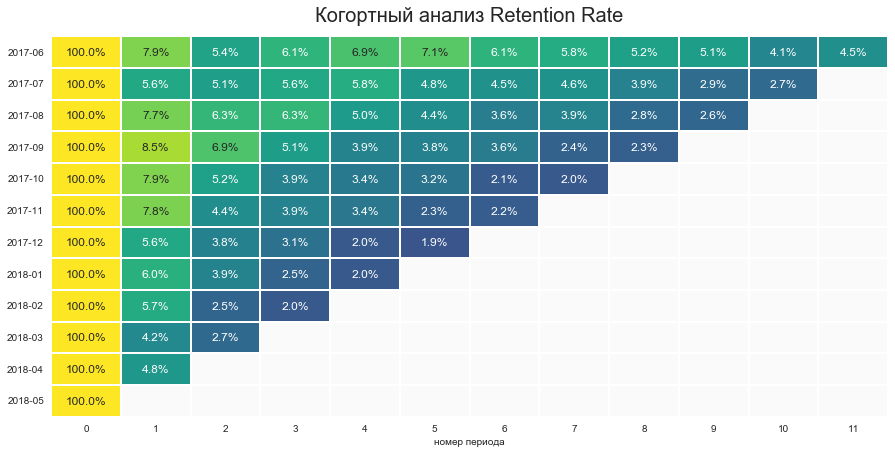

In [322]:
# визуализация Retention Rate по когортам и периодам

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))

ax = sns.heatmap(
                 visit_cohorts_retention,
                 annot=True,
                 annot_kws={"size":'12'},
                 fmt='.1%',
                 linewidths=1,
                 vmax=0.1,
                 vmin=-0.01,
                 cmap= 'viridis',
                 cbar=False
                )

ax.set_title('Когортный анализ Retention Rate', fontsize=20, pad=15)
ax.set_xlabel('номер периода')
ax.set_ylabel('')
ax.tick_params(left=False, bottom=False)

space()
plt.show()

In [323]:
# СПЕЦЗАДАНИЕ
# средний Retention Rate на второй месяц «жизни» когорт

# не понятно, что имелось в виду в задании:
#   Retention Rate, усредненный между когортами (для сравнения когорт)
#   или средний Retention Rate всех пользователей (для оценки сервиса в целом)

print('\n',
      'Retention Rate на 2-й месяц «жизни» когорт, усредненный между когортами: {:.2%}'
      .format(
              visit_cohorts.groupby(['lifetime'])
                           .agg({'retention':'mean'})
                           .loc[1, 'retention']
             )
     )

print('\n',
      'Retention Rate на 2-й месяц «жизни» когорт, для сервиса в целом: {:.2%}'
      .format(
              visit_cohorts.groupby(['lifetime'])
                           .agg({'users_qnty':'sum'})
                           .loc[1, 'users_qnty'] 
              /
              visit_cohorts.groupby(['lifetime'])
                           .agg({'users_qnty_0':'sum'})
                           .loc[1, 'users_qnty_0']
             )
     )


 Retention Rate на 2-й месяц «жизни» когорт, усредненный между когортами: 6.52%

 Retention Rate на 2-й месяц «жизни» когорт, для сервиса в целом: 6.49%


### Вывод по продуктовым метрикам

**DAU, WAU и MAU**

Графики DAU, WAU и MAU показывают существенный приток посетителей в первую половину исследуемого периода (от лета к концу года) и почти такой же существенный отток в следующую половину исследуемого периода (с начала года к лету).

**Retention Rate (RR)**

На второй месяц продолжает пользоваться сервисом лишь малая часть пользователей: около 6.5%. Учитывая, что в среднем на одного пользователя приходится лишь около 1.3 сессии в месяц, можно утверждать, что большинство пользователей, которых мы не увидели на второй месяц, перестали пользоваться сервисом уже после первого же посещения.

Среди пользователей, продолживших использование сервиса, дальнейший отток уже не выглядит таким катастрофическим и может быть в пределах естественной убыли (какую величину считать естественной убылью -- требуется дополнительная информация/исследование).

Анализ DAU, WAU и MAU показал, что активность пользователей зависит от времени года. Поэтому сравнение RR по когортам целесообразно делать не только по столбцам, сравнивая когорты в определенный период жизни, но и ***по диагонали, сравнивая их поведение в одинаковое время года.*** Такое сравнение показывает, что когорты гораздо больше похожи, чем если сравнивать их по столбцам.

Дополнительно можно выделить 2 когорты:
- **[2017-06]**: имеет более высокий RR на протяженни всего анализируемого периода; возможно, это связано с акцией, имеющей долгосрочный эффект;
- **[2017-09]** (и похожие на нее 2017-10, 2017-11): имеет повышенный RR в начале и быстрое снижение до уровня сезонного соответствия; возможно, это связано с краткосрочной акцией (этот эффект также проявляется в повышении RR для когорты **[2017-06]** в это же время года).

**Продолжительность визита**

Большое количество коротких сессий в совокупности с низким начальным RR может быть следствием того, что:
 - новые посетители, не углубляясь в изучение сайта, очень быстро отказываются от его использования. Возможно, есть различие в поведении посетителей на различных типах устройств. Это требует дополнительного исследования;
 - посетители приходят из партнерских источников по прямым ссылкам для уточнения деталей или сразу для совершения покупки. Эта версия также требует дополнительной проверки.

В любом случае необходимо искать причину большого количества очень коротких сессий.

---
## Метрики электронной коммерции

### Время с момента первого посещения сайта до первой покупки

In [324]:
# подготовка дат

orders['year'] = orders['ts_order'].dt.year
orders['month'] = orders['ts_order'].dt.month
orders['week'] = orders['ts_order'].dt.week
orders['date'] = orders['ts_order'].dt.date.astype('datetime64')
orders['date_short'] = orders['date'].dt.strftime('%Y-%m')

# расчет времени между первым визитом и первой покупкой (в минутах)

first_visit = visits.groupby('id_user')['ts_start'].min().reset_index()
first_order = orders.groupby('id_user')['ts_order'].min().reset_index()
first_order = first_order.merge(first_visit, on='id_user')

first_order['visit_to_order_time'] = (
                            (first_order['ts_order'] - first_order['ts_start']) / np.timedelta64(1,'m')
                                     ).round().astype('Int64')

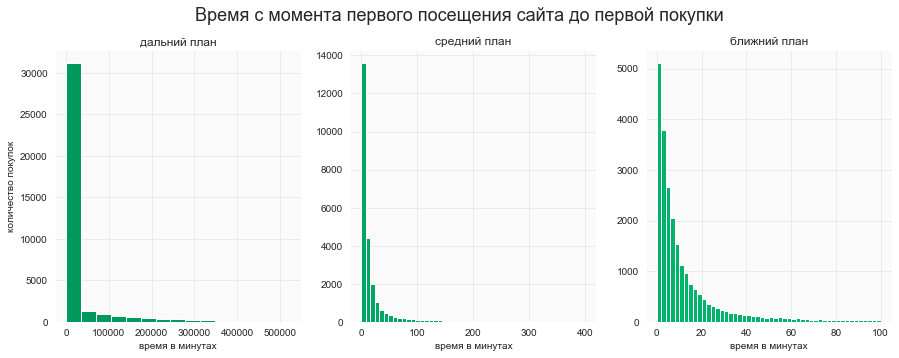

----------------------------------------------
Время от первого визита до покупки (в минутах)

  в среднем: 24341
  медианно: 16
  модально: 1




In [325]:
# графики

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
fig.subplots_adjust(wspace=0.2, hspace=0)
fig.suptitle('Время с момента первого посещения сайта до первой покупки', fontsize=18, y=1)

first_order['visit_to_order_time'].hist(ax=axes[0], bins=15, color='#00995c')
axes[0].set_title('дальний план', fontsize=12, pad=5)
axes[0].set_xlabel('время в минутах')
axes[0].set_ylabel('количество покупок')

first_order['visit_to_order_time'].hist(ax=axes[1], bins=50, color='#00a663', range=(0, 400))
axes[1].set_title('средний план', fontsize=12, pad=5)
axes[1].set_xlabel('время в минутах')
axes[1].set_ylabel('')

first_order['visit_to_order_time'].hist(ax=axes[2], bins=50, color='#00b36b', range=(0, 100))
axes[2].set_title('ближний план', fontsize=12, pad=5)
axes[2].set_xlabel('время в минутах')
axes[2].set_ylabel('')

space()
plt.show()

print('----------------------------------------------')
print('Время от первого визита до покупки (в минутах)' + '\n')
print('  в среднем: {:.0f}'.format(first_order['visit_to_order_time'].mean()) )
print('  медианно: {:.0f}'.format(first_order['visit_to_order_time'].median()) )
print('  модально: {}'.format(int(first_order['visit_to_order_time'].mode())) )
space()

### Динамика среднего количества покупок на одного покупателя

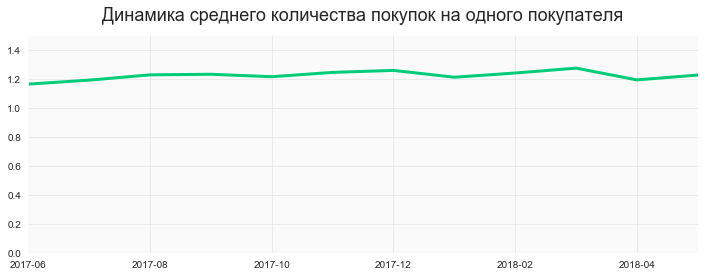

,user_orders,user_count,orders_per_user
date_short,,,
2017-06,2354,2023,1.16
2017-07,2363,1984,1.19
2017-08,1807,1472,1.23
2017-09,3387,2750,1.23
2017-10,5679,4675,1.21
2017-11,5659,4547,1.24
2017-12,6218,4942,1.26
2018-01,4721,3898,1.21
2018-02,5281,4258,1.24


In [355]:
orders_by_month = orders.groupby('date_short').agg({'id_user':['count', 'nunique']})
orders_by_month.columns = ['user_orders', 'user_count']
orders_by_month['orders_per_user'] = orders_by_month['user_orders'] / orders_by_month['user_count']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

orders_by_month.plot(
                     ax=axes,
                     y='orders_per_user',
                     color='#00cc7a',
                     linewidth=3,
                     legend=False,
                     grid=True
                    )

axes.set_title('Динамика среднего количества покупок на одного покупателя', fontsize=18, pad=15)
axes.set_xlabel('')
axes.set_ylim(0,1.5)
plt.show()

display(orders_by_month)

### Среднее количество покупок на одного покупателя за определённый период

In [327]:
# покупатель включается в расчет
# даже если с момента его первого визита
# не прошло указанное количество дней

PERIOD = 182    # за какой период сделать расчет (в днях)

user_first_period = visits.groupby('id_user').agg({'ts_start': 'min'})
user_first_period['ts_end'] = user_first_period['ts_start'] + pd.Timedelta(days=PERIOD)

users_orders = (
                pd.merge(user_first_period,
                         orders[['id_user', 'ts_order']],
                         on='id_user')
                .query('ts_start <= ts_order <= ts_end')
               )

orders_qnty_by_user = float(
                            users_orders
                            .groupby('id_user')
                            .agg({'ts_end':'count'}).mean()
                           )

print('\n',
      'в течение {} дней с момента первого посещения покупатель делает в среднем {:.2f} покупки'
      .format(PERIOD, orders_qnty_by_user)
      )


 в течение 182 дней с момента первого посещения покупатель делает в среднем 1.32 покупки


### Динамика среднего чека

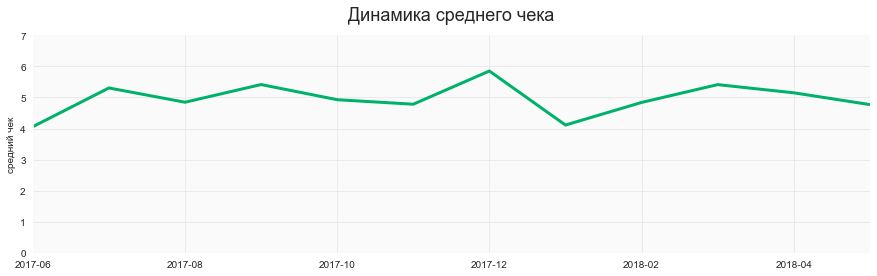

,revenue_sum,revenue_count,revenue_average
date_short,,,
2017-06,9557.49,2354,4.06
2017-07,12539.47,2363,5.31
2017-08,8758.78,1807,4.85
2017-09,18345.51,3387,5.42
2017-10,27987.70,5679,4.93
2017-11,27069.93,5659,4.78
2017-12,36388.60,6218,5.85
2018-01,19417.13,4721,4.11
2018-02,25560.54,5281,4.84


средний чек за весь период наблюдений: 5.00 у.е.


In [328]:
# расчет

orders_by_month = orders.groupby('date_short').agg({'revenue':['sum', 'count']})
orders_by_month.columns = ['revenue_sum', 'revenue_count']
orders_by_month['revenue_average'] = orders_by_month['revenue_sum'] / orders_by_month['revenue_count']

# график

fig, axes = plt.subplots(figsize=(15,4))

orders_by_month.plot(
                     ax=axes,
                     y='revenue_average',
                     linewidth=3,
                     color='#00b16a',
                     legend=False
                    )

axes.set_title('Динамика среднего чека', fontsize=18, pad=15)
axes.set_ylim(0,7)
axes.set_xlabel('')
axes.set_ylabel('средний чек')
plt.show()

display(orders_by_month)

print(
      font.BOLD +
      'средний чек за весь период наблюдений: {:.2f} у.е.'
      .format(orders['revenue'].sum() / orders['revenue'].count()) +
      font.END
     )

### Динамика LTV на покупателя по когортам

In [329]:
# константы

MARGIN_RATE = 1     # маржинальность сервиса — 100%
LIFETIME_LIMIT = 6  # анализ для когорт, «проживших» не менее 6 месяцев
PERIODS_FIRST = 6   # кол-во первых периодов (месяцев),
                    # за которые нужно проанализировать выбранные когорты (может отличаться от LIFETIME_LIMIT)

In [330]:
# первый заказ

first_order = orders.groupby('id_user')['date'].min()
first_order.name='first_order_month'
orders = orders.join(first_order, on='id_user')

In [331]:
# разделение заказов на периоды, совпадающие с календарным месяцем

orders['order_month'] =  orders['date'].astype('datetime64[M]')
orders['first_order'] = orders['first_order_month']
orders['first_order_month'] = orders['first_order_month'].astype('datetime64[M]')

In [332]:
# формирование когорт

orders['lifetime'] = (
                      ((orders['order_month'] - orders['first_order_month']) / np.timedelta64(1,'M'))
                      .round()
                      .astype('int')
                     )

order_cohorts = (
                 orders
                 .groupby(['first_order_month','lifetime'])
                 ['revenue']
                 .sum()
                 .reset_index()
                 .rename(columns={'revenue':'revenue_sum'})
                )

order_cohorts_size = (
                      orders.groupby('first_order_month')
                      .agg({'id_user': 'nunique'})
                      .reset_index()
                      .rename(columns={'id_user':'user_qnty'})
                     )

order_cohorts = order_cohorts.merge(order_cohorts_size, on='first_order_month')

In [333]:
# расчет LTV по когортам и периодам

order_cohorts['gross_income'] = order_cohorts['revenue_sum'] * MARGIN_RATE          # валовая прибыль
order_cohorts['ltv'] = order_cohorts['gross_income'] / order_cohorts['user_qnty']

In [334]:
# определение возраста когорты на конец периода исследования

order_cohorts_lifiteme_max = (
                              order_cohorts
                              .groupby('first_order_month')
                              ['lifetime']
                              .max()
                              .reset_index()
                              .rename(columns={'lifetime': 'lifetime_max'})
                             )

order_cohorts = pd.merge(
                         order_cohorts, 
                         order_cohorts_lifiteme_max,
                         on='first_order_month'
                        )

order_cohorts['first_order_month_short'] = order_cohorts['first_order_month'].dt.strftime('%Y-%m')

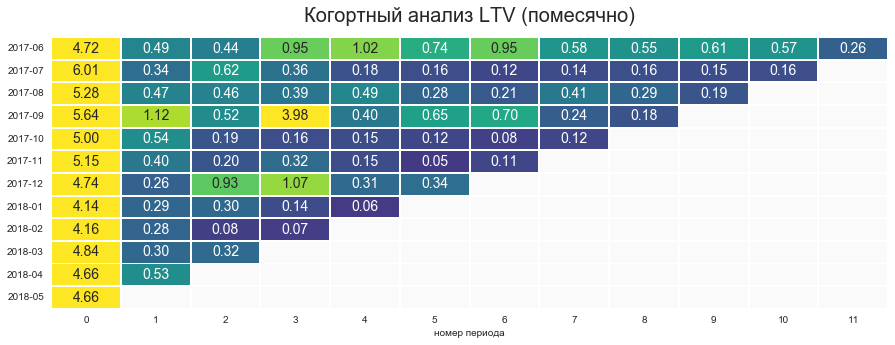

In [358]:
# визуализация LTV по когортам и периодам (пока без фильтра по возрасту когорт)

order_cohorts_ltv = (
                     order_cohorts
                     .pivot_table(
                                  index='first_order_month_short',
                                  columns='lifetime',
                                  values='ltv',
                                  aggfunc='mean',
                                 )
                    )

fig, axes = plt.subplots(figsize=(15,5))

axes = sns.heatmap(order_cohorts_ltv,
                   annot=True,
                   annot_kws={'size':'14'},
                   fmt='.2f',
                   linewidths=1,
                   vmax=1.3,
                   vmin=-0.2,
                   cmap= 'viridis',
                   cbar=False)

axes.set_title('Когортный анализ LTV (помесячно)', fontsize=20, pad=15)
axes.set_xlabel('номер периода')
axes.set_ylabel('')
axes.tick_params(left=False, bottom=False)

space()
plt.show()
space()

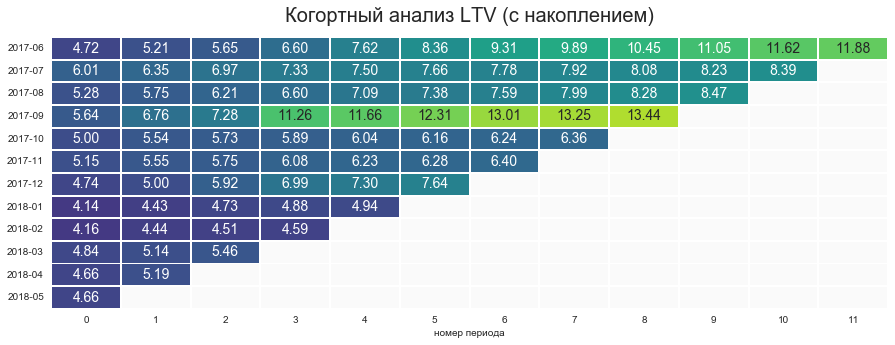

In [359]:
# преобразование помесячных данных в накопительные

order_cohorts_ltv_cumulative = order_cohorts_ltv.cumsum(axis=1)

fig, axes = plt.subplots(figsize=(15,5))

axes = sns.heatmap(order_cohorts_ltv_cumulative,
                 annot=True,
                 annot_kws={'size':'14'},
                 fmt='.2f',
                 linewidths=1,
                 vmax=15,
                 vmin=2,
                 cmap= 'viridis',
                 cbar=False)

axes.set_title('Когортный анализ LTV (с накоплением)', fontsize= 20, pad=15)
axes.set_xlabel('номер периода')
axes.set_ylabel('')
axes.tick_params(left=False, bottom=False)

space()
plt.show()
space()

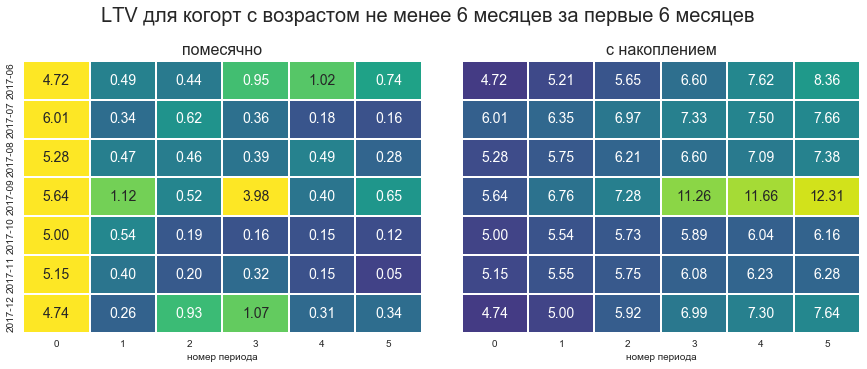

Средний LTV по когортам за первые 6 месяцев для когорт, «проживших» не менее 6 месяцев: 7.97 у.е.




In [360]:
# визуализация LTV по когортам и периодам (за первые 6 месяцев)

order_cohorts_ltv = (
                     order_cohorts
                     .query('lifetime_max >= @LIFETIME_LIMIT-1 & lifetime < @PERIODS_FIRST')
                     .pivot_table(
                                  index='first_order_month_short',
                                  columns='lifetime',
                                  values='ltv',
                                  aggfunc='mean'
                                 )
                    )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('LTV для когорт с возрастом не менее {} месяцев за первые 6 месяцев'.format(LIFETIME_LIMIT), fontsize=20, y=1.03)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

sns.heatmap(
            order_cohorts_ltv,
            ax=axes[0],
            annot=True,
            annot_kws={'size':'14'},
            fmt='.2f',
            linewidths=1,
            vmax=1.5,
            vmin=-0.3,
            cmap= 'viridis',
            cbar=False
           )

axes[0].set_title('помесячно', fontsize= 16)
axes[0].set_xlabel('номер периода')
axes[0].set_ylabel('')
axes[0].tick_params(left=False, bottom=False)


# преобразование помесячных данных в накопительные

order_cohorts_ltv_cumulative = order_cohorts_ltv.cumsum(axis=1)

sns.heatmap(
            order_cohorts_ltv_cumulative,
            ax=axes[1],
            annot=True,
            annot_kws={'size':'14'},
            fmt='.2f',
            linewidths=1,
            vmax=13,
            vmin=3,
            cmap= 'viridis',
            cbar=False
           )
axes[1].set_title('с накоплением', fontsize= 16)
axes[1].set_xlabel('номер периода')
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
axes[1].tick_params(left=False, bottom=False)

space()
plt.show()

print(
      font.BOLD +
      'Средний LTV по когортам за первые {} месяцев для когорт, «проживших» не менее {} месяцев: {:.2f} у.е.'
      .format(LIFETIME_LIMIT,
              PERIODS_FIRST,
              order_cohorts_ltv_cumulative.loc[:, 5].mean()) +
      font.END
     )
space()

In [362]:
# небольшая дополнительная проверка
# количество заказов, сделанных во время первого визита

print('\n', 'всего заказов:', len(orders))

user_first_visit = visits.groupby('id_user').agg({'ts_start': 'min', 'ts_end': 'min'})
user_first_order = orders.groupby('id_user').agg({'ts_order': 'min'})

fast_users = (
              pd.merge(user_first_visit,
                       user_first_order,
                       on='id_user')
              .query('ts_start <= ts_order <= ts_end')
             )

print('\n', 
      'всего быстрых заказов (в первый визит):',
      len(fast_users),
      'или {:.0%}'
      .format(len(fast_users) / len(orders)),
      '\n'
     )



 всего заказов: 50414

 всего быстрых заказов (в первый визит): 21187 или 42% 



In [363]:
# и еще небольшая дополнительная проверка
# количество покупателей, сделавших единственный заказ

buyers_total = len(orders.groupby('id_user').agg({'ts_order':'count'}))
buyers_once = len(orders.groupby('id_user').agg({'ts_order':'count'}).query('ts_order == 1'))

print('\n', 
      'доля покупателей, сделавших единственный заказ {:.0%}:'
      .format(buyers_once / buyers_total)
     )


 доля покупателей, сделавших единственный заказ 83%:


### Вывод по метрикам электронной коммерции

**Время от первого визита до первой покупки**

Характер распределения времени от первого посещения до первой покупки выглядит крайне странно. Судя по нему, подавляющее большинство пользователей совершают покупку едва ли не в первый визит.

> Дополнительная проверка показала, что **42%** пользователей совершают покупку во время первого визита.

Учитывая низкий начальный  Retantion Rate и высокую долю покупок при первом визите, можно предположить, что сайт имеет проблемы с идентификацией пользователей, принимая старых посетителей за новых.

"Нулевая" длительность с момента первого входа до первой покупки может означать, что пользователь сделал покупку менее, чем за минуту (например, зашел по прямой ссылке на форму отправки заказа).

**Средний чек**

Динамика среднего чека устойчива во времени. Средний чек за весь период исследований составляет 5.00 у.е. Наибольший средний чек отмечен в декабре, наименьший -- в январе. Повышение цен перед новогодними праздниками выглядит логичным. Падение цен в январе может быть связано, например, с тем, что:
- билеты приобретаются заранее и, возможно, в январе мы имеем значительную долю покупок на февральские мероприятия;
- в январе продается больше детских билетов, и цена на них может быть ниже.
Дополнительное исследование падения среднего чека в январе также не помешает.

**Когортный анализ LTV**

Исследованы когорты, имеющие возраст не менее 6 месяцев.

Для всех когорт характерно высокое значение LTV в первый месяц.

Особо выделилась когорта **[2017-09]**, преимущественно в декабре: за небольшим исключением, подтверждающим правило, LTV существенно превышает как результаты этой же когорты в другие месяцы, так и результаты других когорт в декабре. Причину этой аномалии необходимо найти в дополнительном исследовании.

Интересно, что самая неудачная когорта следует сразу за особо выдающейся. Возможно, это результат некой акции. В таком случае при проведении акций нужно учитывать не только положительный эффект на целевую когорту, но и негативный на остальные.

За исключением аномальной когорты остальные демонстрируют близкие результаты: максимальный разброс LTV за 6 месяцев не превышает 35%.

**Дополнительно**

В течение первых 6 месяцев один покупатель делает в среднем **1.32** заказа. Покупатель включается в расчет, даже если с момента его первого визита не прошел требуемый срок.

> **83%** процента покупателей делают единственный заказ.

---
## Маркетинговые метрики

### Расходы на маркетинг

In [340]:
# подготовка дат
costs['year'] = costs['date'].dt.year
costs['month'] = costs['date'].dt.month
costs['week'] = costs['date'].dt.week
costs['date_M'] = costs['date'].astype('datetime64[M]')  # требуется для безболезненного join 
costs['date_short'] = costs['date'].dt.strftime('%Y-%m')

# определение (первичного) источника трафика для каждого пользователя

user_source = visits.query('ts_start == first_visit')[['id_user', 'id_source']]
orders = orders.merge(user_source, on='id_user')

#### Общая сумма расходов

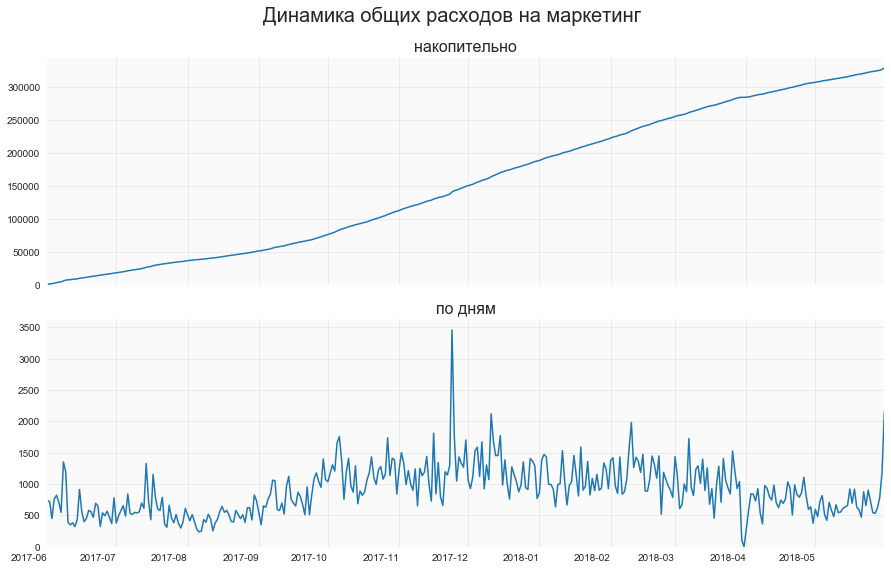

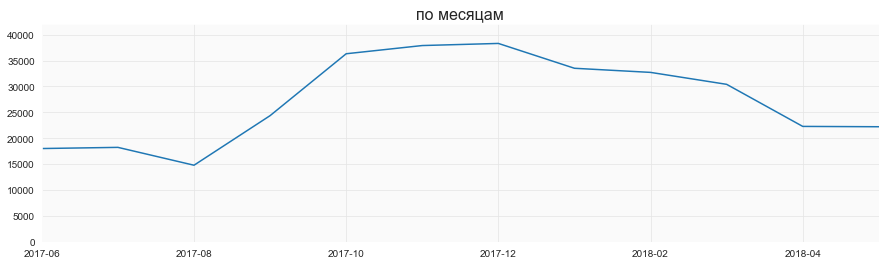


Общая сумма расходов на маркетинг: 329131.62 у.е. 



In [365]:
# графики

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True)
fig.suptitle('Динамика общих расходов на маркетинг', fontsize=20, y=0.95)
fig.subplots_adjust(wspace=0, hspace=0.15)

axes[0] = (
           costs
           .groupby('date')
           ['costs']
           .agg('sum')
           .cumsum()
           .plot(
                 ax=axes[0],
                 x='date',
                 y='costs',
                 grid=True,
                 legend=False
                )
          )
axes[0].set_title('накопительно', fontsize=16)
axes[0].set_ylim(0, )

axes[1] = (
           costs
           .groupby('date')
           ['costs']
           .agg('sum')
           .plot(
                 ax=axes[1],
                 x='date',
                 y='costs',  
                 grid=True,
                 legend=False
                )
          )
axes[1].set_title('по дням', fontsize=16)
axes[1].set_ylim(0, )
axes[1].set_xlabel('')
plt.xticks(rotation = 0)

space()
plt.show()

fig, axes = plt.subplots(figsize=(15,4))

axes = (
        costs
        .groupby('date_short')
        ['costs']
        .agg('sum')
        .plot(
              ax=axes,
              x='date',
              y='costs',  
              grid=True,
              legend=False
             )
       )
axes.set_title('по месяцам', fontsize=16)
axes.set_ylim(0, 42000)
axes.set_xlabel('')
plt.xticks(rotation = 0)

plt.show()

# текст

print(
      font.BOLD + 
      '\n' + 'Общая сумма расходов на маркетинг: {:.2f} у.е.'
      .format(costs['costs'].sum()) +
      font.END,
      '\n'
     )

#### Расходы по источникам

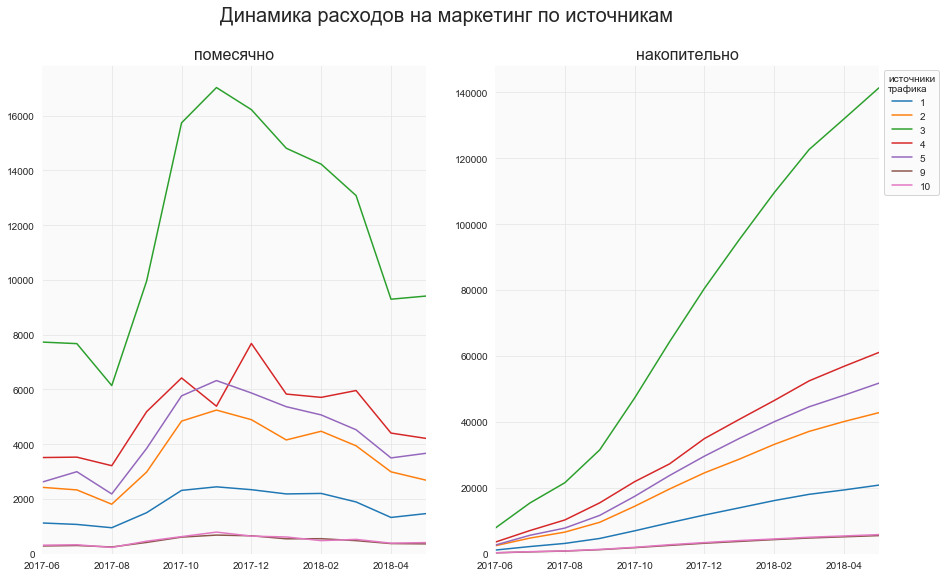



Суммарные расходы по источникам и месяцам, плюс итоги:


id_source,1,2,3,4,5,9,10,TOTAL,%
date_short,,,,,,,,,
2017-06,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22,18015.00,5.47
2017-07,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82,18240.59,5.54
2017-08,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57,14790.54,4.49
2017-09,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67,24368.91,7.40
2017-10,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24,36322.88,11.04
2017-11,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36,37907.88,11.52
2017-12,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86,38315.35,11.64
2018-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35,33518.52,10.18
2018-02,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88,32723.03,9.94


In [367]:
# графики

costs_by_source = costs.pivot_table(
                                    index='date_short',
                                    columns='id_source',
                                    values='costs',
                                    aggfunc='sum'
                                   )

costs_by_source_cumulative = costs_by_source.cumsum(axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,9))
fig.suptitle('Динамика расходов на маркетинг по источникам', fontsize=20, y=0.97)
fig.subplots_adjust(wspace=0.18, hspace=0.0)

costs_by_source.plot(
                     ax=axes[0],
                     grid=True,
                     legend=False
                    )

axes[0].set_title('помесячно', fontsize=16)
axes[0].set_xlabel('')
axes[0].set_ylim(0, )


costs_by_source_cumulative.plot(
                                ax=axes[1],
                                grid=True
                               )

axes[1].set_title('накопительно', fontsize=16)
axes[1].set_xlabel('')
axes[1].set_ylim(0, )
axes[1].legend(title='источники\n' + 'трафика', loc='upper left', bbox_to_anchor=(1, 1))

space()
plt.show()


# таблица

space()
print('Суммарные расходы по источникам и месяцам, плюс итоги:')

costs_by_source = costs.pivot_table(index='date_short',
                                    columns='id_source',
                                    values='costs',
                                    aggfunc='sum',
                                    margins=True,
                                    margins_name='TOTAL')

costs_total = costs_by_source.loc['TOTAL', 'TOTAL']
costs_by_source['%'] = costs_by_source['TOTAL'] / costs_total * 100

# ДОРАБОТАТЬ: автоматизировать циклом (или поискать другой вариант)
percent_row = pd.Series(data={
                              1:costs_by_source.loc['TOTAL', 1] / costs_total * 100,
                              2:costs_by_source.loc['TOTAL', 2] / costs_total * 100,
                              3:costs_by_source.loc['TOTAL', 3] / costs_total * 100,
                              4:costs_by_source.loc['TOTAL', 4] / costs_total * 100,
                              5:costs_by_source.loc['TOTAL', 5] / costs_total * 100,
                              9:costs_by_source.loc['TOTAL', 9] / costs_total * 100,
                              10:costs_by_source.loc['TOTAL', 10] / costs_total * 100,
                              'TOTAL':costs_by_source.loc['TOTAL', 'TOTAL'] / costs_total * 100,
                              '%':100
                             },
                        name='%'
                       )
costs_by_source = costs_by_source.append(percent_row, ignore_index=False)

display(costs_by_source)

### Динамика прихода новых пользователей в зависимости от источника

*Зачем-то сделал. Пока не придумал, к какому разделу отнести.*

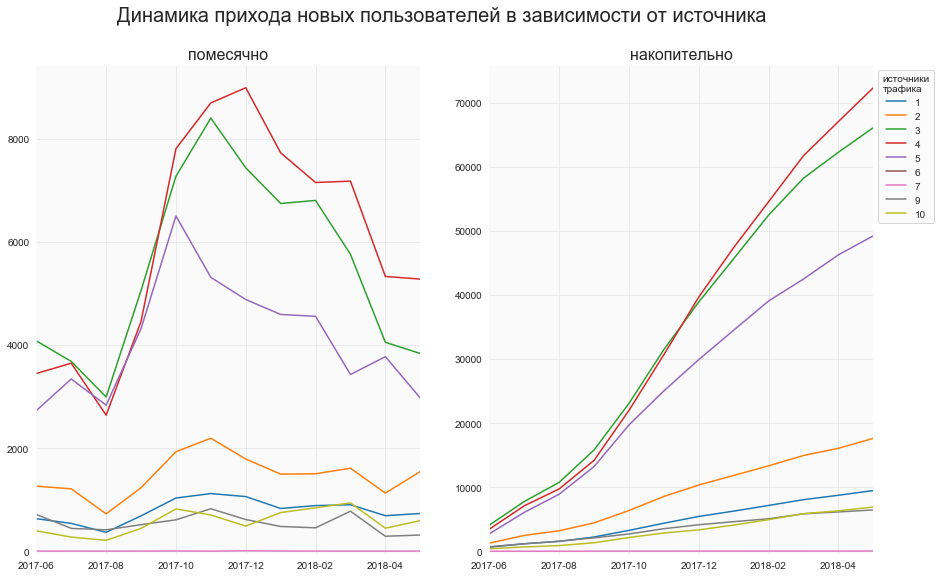

In [369]:
source_cohorts = (
                  visits
                  .query('ts_start == first_visit')             # учитывается только первое посещение пользователя
                  .pivot_table(
                               index='first_visit_month_short',
                               columns='id_source',
                               values='id_user',
                               aggfunc='count'
                              )
                )

source_cohorts_cumulative = source_cohorts.cumsum(axis=0)

# графики

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,9))
fig.suptitle('Динамика прихода новых пользователей в зависимости от источника', fontsize=20, y=0.97)
fig.subplots_adjust(wspace=0.18, hspace=0.0)


source_cohorts.plot(ax=axes[0], grid=True, legend=False)

axes[0].set_title('помесячно', fontsize= 16)
axes[0].set_xlabel('')
axes[0].set_ylim(-50, )


source_cohorts_cumulative.plot(ax=axes[1], grid=True)

axes[1].set_title('накопительно', fontsize= 16)
axes[1].set_xlabel('')
axes[1].set_ylim(-400, )
axes[1].legend(title='источники\n' + 'трафика', loc='upper left', bbox_to_anchor=(1, 1))


space()
plt.show()
space()

### Динамика дохода в зависимости от источника

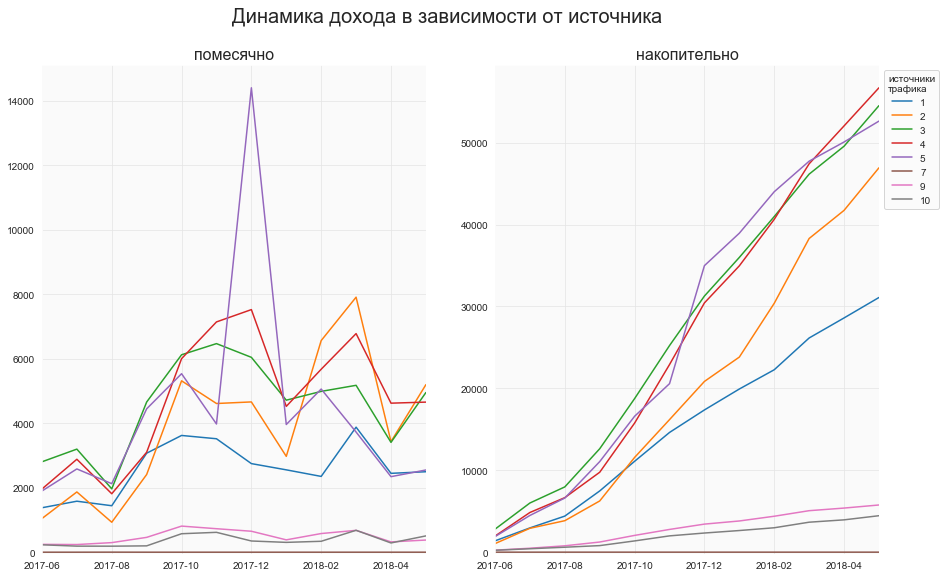

In [370]:
# доход (revenue) по источникам трафика

orders_pivot = orders.pivot_table(index='date_short', columns='id_source', values='revenue', aggfunc='sum', margins=False).fillna(0)
orders_pivot_cumulative = orders_pivot.cumsum(axis=0)

# графики

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,9))
fig.suptitle('Динамика дохода в зависимости от источника', fontsize=20, y=0.97)
fig.subplots_adjust(wspace=0.18, hspace=0.0)


orders_pivot.plot(ax=axes[0], grid=True, legend=False)

axes[0].set_title('помесячно', fontsize= 16)
axes[0].set_xlabel('')
axes[0].set_ylim(-50, )


orders_pivot_cumulative.plot(ax=axes[1], grid=True)

axes[1].set_title('накопительно', fontsize= 16)
axes[1].set_xlabel('')
axes[1].set_ylim(-200, )
axes[1].legend(title='источники\n' + 'трафика', loc='upper left', bbox_to_anchor=(1, 1))

space()
plt.show()
space()

### Средний CAC на одного покупателя

In [371]:
# CAC, сгруппированный по маркетинговым источникам

CAC_sources = (
               pd.merge(
                        orders
                            .groupby(['first_order_month', 'id_source'])
                            .agg({'id_user': 'count'})
                            .reset_index(),
                        costs
                            .groupby(['date_M', 'id_source'])
                            .agg({'costs': 'sum'})
                            .reset_index()
                            .rename(columns={'date_M': 'first_order_month'}),
                        how='outer',
                        on=['first_order_month', 'id_source']
                       )
                       .fillna(0)
                       .rename(columns={'id_user': 'users_qnty'})
              )

CAC_sources['cac'] = CAC_sources['costs'] / CAC_sources['users_qnty']
CAC_sources['first_order_month_short'] = CAC_sources['first_order_month'].dt.strftime('%Y-%m')

space()
display(CAC_sources.sample(3))
space()

,first_order_month,id_source,users_qnty,costs,cac,first_order_month_short
81,2018-05-01,4,869,4214.21,4.85,2018-05
19,2017-08-01,7,1,0.00,0.00,2017-08
55,2018-01-01,9,108,547.16,5.07,2018-01


In [372]:
# CAC общий (без группировки по маркетинговым источникам)

CAC_total = (
             pd.merge(
                      orders
                          .groupby(['first_order_month'])
                          .agg({'id_user': 'count'})
                          .reset_index(),
                      costs
                          .groupby(['date_M'])
                          .agg({'costs': 'sum'})
                          .reset_index()
                          .rename(columns={'date_M': 'first_order_month'}),
                      how='outer',
                      on=['first_order_month']
                     )
                     .fillna(0)
                     .rename(columns={'id_user': 'users_qnty'})
            )

CAC_total['cac'] = CAC_total['costs'] / CAC_total['users_qnty']
CAC_total['first_order_month_short'] = CAC_total['first_order_month'].dt.strftime('%Y-%m')

space()
display(CAC_total)
space()

,first_order_month,users_qnty,costs,cac,first_order_month_short
0,2017-06-01,4438,18015.00,4.06,2017-06
1,2017-07-01,2910,18240.59,6.27,2017-07
2,2017-08-01,2188,14790.54,6.76,2017-08
3,2017-09-01,3878,24368.91,6.28,2017-09
4,2017-10-01,6005,36322.88,6.05,2017-10
5,2017-11-01,5900,37907.88,6.43,2017-11
6,2017-12-01,5894,38315.35,6.50,2017-12
7,2018-01-01,4308,33518.52,7.78,2018-01
8,2018-02-01,4470,32723.03,7.32,2018-02
9,2018-03-01,4484,30415.27,6.78,2018-03


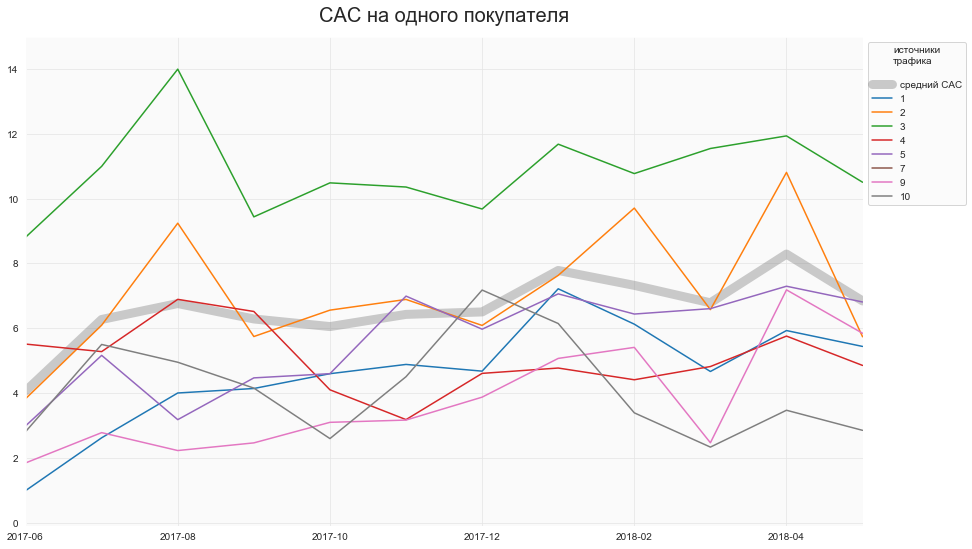

In [373]:
# графики

CAC_sources_pivot = CAC_sources.pivot_table(index='first_order_month_short',
                                            columns='id_source',
                                            values='cac',
                                            aggfunc='mean')

CAC_total_pivot = CAC_total.pivot_table(index='first_order_month_short',
                                        values='cac',
                                        aggfunc='mean').rename(columns={'cac':'средний CAC'})

fig, axes = plt.subplots(figsize=(15,9))

CAC_total_pivot.plot(
                     ax=axes,
                     grid=True,
                     legend=False,
                     linewidth=9,
                     color='grey',
                     alpha=0.4
                    )

CAC_sources_pivot.plot(
                       ax=axes,
                       grid=True,
                       legend=False
                      )

axes.set_title('CAC на одного покупателя', fontsize= 20, pad=15)
axes.set_xlabel('')
axes.set_ylim(-0.1, 15)
axes.legend(title='источники\n' + 'трафика\n', loc='upper left', bbox_to_anchor=(1, 1))

space()
plt.show()
space()

### Когортный анализ ROMI

#### ROMI без разделения на источники

In [348]:
ROMI = pd.merge(
                order_cohorts, 
                CAC_total[['first_order_month', 'costs']],
                on='first_order_month'
               )

ROMI['cac'] = ROMI['costs'] / ROMI['user_qnty']
ROMI['romi'] = ROMI['ltv'] /  ROMI['cac']

ROMI['first_order_month_short'] = ROMI['first_order_month'].dt.strftime('%Y-%m')

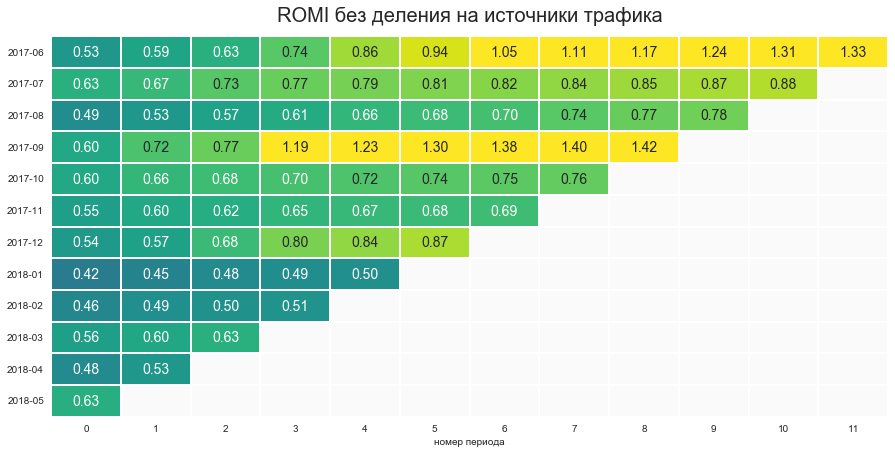

In [374]:
# визуализация ROMI по когортам и периодам

ROMI_pivot = (
              ROMI
              .pivot_table(index='first_order_month_short',
                           columns='lifetime',
                           values='romi',
                           aggfunc='mean')
              .cumsum(axis=1)
             )

plt.figure(figsize = (15, 7))

ax = sns.heatmap(ROMI_pivot,
                 annot=True,
                 annot_kws={"size":'14'},
                 fmt='.2f',
                 linewidths=1,
                 vmax=1,
                 vmin=0,
                 cmap= 'viridis',
                 cbar=False)

ax.set_title('ROMI без деления на источники трафика', fontsize=20, pad=15)
ax.set_xlabel('номер периода')
ax.set_ylabel('')
ax.tick_params(left=False, bottom=False)

space()
plt.show()
space()

#### ROMI по источникам

In [350]:
# формирование когорт

sources_order_cohorts = (
                         orders
                         .groupby(['id_source', 'first_order_month', 'lifetime'])
                         ['revenue']
                         .sum()
                         .reset_index()
                         .rename(columns={'revenue':'revenue_sum'})
                        )

sources_order_cohorts_size = (
                              orders
                              .groupby(['id_source', 'first_order_month'])
                              .agg({'id_user': 'nunique'})
                              .reset_index()
                              .rename(columns={'id_user':'user_qnty'})
                             )

sources_order_cohorts = sources_order_cohorts.merge(sources_order_cohorts_size,
                                                    on=['id_source', 'first_order_month']
                                                   )

# расчет LTV

sources_order_cohorts['gross_income'] = sources_order_cohorts['revenue_sum'] * MARGIN_RATE

sources_order_cohorts['ltv'] = sources_order_cohorts['gross_income'] / sources_order_cohorts['user_qnty']

In [351]:
# расчет ROMI

ROMI_sources = pd.merge(
                        sources_order_cohorts, 
                        CAC_sources[['id_source', 'first_order_month', 'costs']],
                        on=['id_source', 'first_order_month']
                       )

ROMI_sources['cac'] = ROMI_sources['costs'] / ROMI_sources['user_qnty']
ROMI_sources['romi'] = ROMI_sources['ltv'] /  ROMI_sources['cac']

ROMI_sources['first_order_month_short'] = ROMI_sources['first_order_month'].dt.strftime('%Y-%m')

In [352]:
# визуализация ROMI по источникам, когортам и периодам (подготовка subplot)

def plot_ROMI(id_src, i, j):
       
    ROMI_pivot = (
                  ROMI_sources.query('id_source == @id_src')      # фильтрация по источнику трафика
                  .pivot_table(index='first_order_month_short',
                               columns='lifetime',
                               values='romi',
                               aggfunc='mean')
                  .cumsum(axis=1)
                 )

    sns.heatmap(
                ROMI_pivot,
                ax=ax[i,j],
                annot=True,
                annot_kws={"size":'10'},
                fmt='.2f',
                linewidths=1,
                vmax=1,
                vmin=0,
                cmap= 'viridis',
                cbar=False
               )

    ax[i,j].set_title('ROMI для источника id = ' + str(id_src), fontsize=16, loc = 'left', pad=10)
    ax[i,j].set_xlabel('номер периода')
    ax[i,j].set_ylabel('')
    ax[i,j].tick_params(left=False, bottom=False)

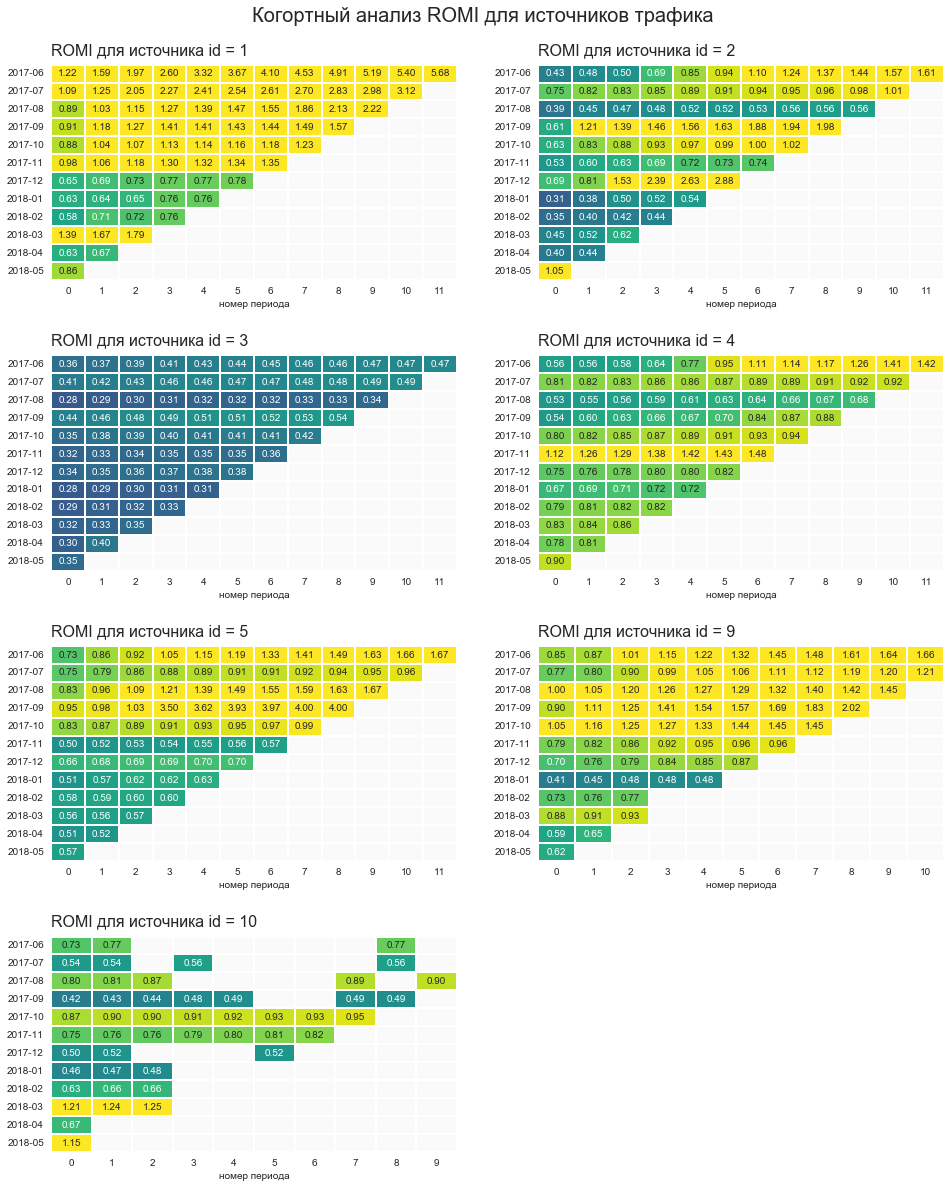

In [375]:
# когортный анализ ROMI отдельно для каждого источника трафика

id_sources_list = ROMI_sources.query('costs > 0')['id_source'].unique().tolist()   # список источников трафика,
                                                                                   # для которых были затраты
# подготовка figure (subplots)
plot_cols = 2                                         # количество колонок в figure
plot_rows = 4                                         # количество строк в figure
subplot_width = 8                                     # ширина каждого sublot
subplot_height = 5                                    # высота каждого sublot 

fig, ax = plt.subplots(
                       nrows=plot_rows,
                       ncols=plot_cols,
                       figsize=(subplot_width*plot_cols, subplot_height*plot_rows)
                      )

fig.suptitle('Когортный анализ ROMI для источников трафика', fontsize=20, y=0.92)
fig.subplots_adjust(wspace=0.2, hspace=0.35)

counter = 0
for id_source in id_sources_list:
    row = counter // plot_cols
    col = counter % plot_cols
    plot_ROMI(id_source, row, col)
    counter += 1

fig.delaxes(ax[3,1])

space()
plt.show()

### Вывод по маркетинговым метрикам

**Расходы на маркетинг**

C сентября 2017 расходы на маркетинг росли в преддверии Нового года, затем постепенно снижались.

Картина расходов на каждый источник трафика очертаниями примерно повторяет общий график. Можно сказать, что суммарные расходы делились между источниками примерно в одинаковой пропорции каждый месяц.

Источник с номером 3 оказался самым дорогим - на него было потрачено 43% общего бюджета.  
На источники трафика с номерами 6, 7 и 8 не было потрачено ничего, покупок от них тоже не было, поэтому из анализа CAC и ROMI они исключены.

На графике привлечения новых пользователей видно, что источник трафика №3 уже не является лидером - его обогнал более дешевый источник №4. Еще один более дешевый источник №5 замыкает тройку лидеров. Остальные источники уже заметно проигрывают первым трем по количеству привлеченных посетителей.

**CAC на одного покупателя**

Средний CAC на протяжении исследуемого периода в основном варьируется в диапазоне 4-6 у.е. и имеет слабовыраженную тенденцию к росту.

Источник №3 - единственный, чей CAC постоянно превышает средний CAC. CAC источника №2 большую часть времени близок к среднему значению, иногда заметно превышая его. Остальные источники имеют CAC ниже среднего.

**ROMI**

C точки зрения окупаемости на конец исследуемого периода, ROMI двух когорт превысил 1: **[2017-06]** (как у самой "старой" и самой стабильной) и **[2017-09]** (как у самой успешной в предновогодний месяц). Динамика остальных когорт не столь радужна и, вполне допустимо, некоторые из них так и не достигнут точки окупаемости.

Анализ ROMI для каждого источника трафика в целом показал прекрасную окупаемость источников №1 и №9 и плохую окупаемость источника №3. Остальные в целом имеют хорошую окупаемость.

Помимо общей картины наблюдается ряд интересных особенностей:
- ROMI когорты [2017-06] существенно выше в источнике №1, в разы превышая другие источники;
- источник №3: различие между ROMI когорт наименее выраженное;
- источник №5: резко ухудшились дела, начиная с когорты [2017-11];
- источник №2: особо выделилась высоким ROMI предновогодняя когорта [2017-12];
- источник №9: резко провалилась посленовогодняя когорта [2018-11];
- источник №10: так мало продаж, что его диаграмма "дырявая" ввиду отсутствия продаж по некоторым когортам в отдельные месяцы.

Наблюдения о характере поведения когорт для каждого источника можно использовать для таргетирования рекламных кампаний, выбирая наиболее подходящий источник трафика.

---
## Вывод общий

### Краткий обзор проведенной работы

В данном исследовании были изучены данные "Яндекс.Афиши" о посещениях сайта, покупках и затратах на маркетинг с начала июня 2017 года по конец мая 2018 года. Оценено качество подготовки этих данных. Входные данные были проверены на пропуски, ошибки и дубликаты. Исправлены незначительные недочеты.

По предоставленным данным были рассчитаны и проанализированы метрики трех видов:
- продуктовые,
- метрики электронной коммерции,
- маркетинговые.

Даны рекомендации по результатам исследования. Определены потенциальные риски и возможности их устранения. Даны рекомендации по дальнейшему развитию исследования.

### Результаты анализа

#### Источники трафика 

Все рассуждения об источниках строятся исходя из предположения, что источники не оказывают взаимного влияния друг на друга.

Для оценки прибыльности источнника в первую очередь важен его ROMI, показывающий коэффициент возврата маркетинговых затрат (относительный показатель). Второй показатель - это валовая прибыль, позволяющая оценить масштаб возврата затрат (абсолютный показатель). Вместо валовой прибыли можно использовать размер самих затрат.

Источники трафика №3, 4 и 5 имеют наибольшую сумму затрат на маркетинг, существенно превышающую сумму затрат других источников. Эти 3 источника оказывают наибольшее влияние на прибыльность сервиса.

1. Источник №3 имеет наихудший ROMI при самых высоких затратах. Очень вероятно, что затраты на этот источник не окупятся в обозримом будущем. Первый кандидат на снижение маркетинговых затрат.

1. Источник №4 привлекает больше всего пользователей, но его ROMI неоднозначен - резко выделяются две когорты, [2017-06] и [2017-11], остальные с трудом выходят на окупаемость. Прежде, чем корректировать расходы на этот источник, необходимо выяснить причины успеха названных когорт.

1. Источник №5 - третий по количеству привлеченных посетителей и имеет хороший ROMI. Однако, начиная с когорты [2017-11], ROMI когорт резко снизился. Необходимо выяснить причины этого снижения. В целом, источник может рассматриваться как кандидат на увеличение маркетинговых затрат.

1. Остальные источники имеют хорошие показатели ROMI, но их аудитория (расходы, доходы) заметно ниже, чем у первых трех. Можно попробовать постепенно увеличивать расходы на эти источники, наблюдая за изменением их аудитории и ROMI.


#### Анализ метрик 

##### Продуктовые метрики

Графики **DAU**, **WAU** и **MAU** показывают существенный приток посетителей в первую половину исследуемого периода (от лета к концу года) и почти такой же существенный отток в следующую половину исследуемого периода (с начала года к лету).

**Retention Rate** существенно падает уже на второй месяц, примерно до 6.5%.  
Учитывая низкое количество сессий на одного пользователя в месяц (менее 1.3) и множество очень коротких сессий, можно предположить, что большая часть посетителей заходит на сайт лишь единожды и больше не возвращается.  
Возможно:
- реклама вводит потенциального посетителя в заблуждение (ложные ожидания; возможно, в рекламе обещана "раздача слонов и материализация духов", а ссылка ведет на концерт очередного чуда-в-перьях);
- сайт не удовлетворяет ожидания заинтересовавшихся пользователей по иным параметрам (цены, условия использования);
- сайт неверно идентифицирует старых пользователей, принимая их за новых.

Активность пользователей зависит от времени года. Сравнение Retention Rate по когортам не только в определенный период жизни, но и в одинаковые календарные месяцы показывает, что у когорт гораздо меньше различий, чем кажется на первый взгляд.

##### Метрики электронной коммерции

Распределение **"времени с момента первого посещения сайта до первой покупки"** имеет длиннющий хвост высоких значений. При этом, медиана составляет всего 16 минут, а мода вообще равна 1 минуте. Неправдоподобно, что впервые оказавшийся на сайте посетитель за одну минуту способен найти нужную информацию и оформить заказ. Возможны разные версии, объясняющие этот факт, например:
1. Пользователь переходит на сайт по готовой ссылке для оплаты. В этом случае сайт выступает лишь механизмом для оплаты, остальной функционал пользователя не интересует. Возможно, это также объясняет низкий Retention Rate, особенно если предположить, что:
2. Сайт имеет проблемы с идентификацией пользователей, принимая старых за новых.

Немаловажно, что **42%** покупателей совершают покупку во время первого визита. Эти пользователи зашли на сайт явно с определенной целью.

**83%** покупателей сделали единственную покупку за весь период исследований.

**Средний чек**

Колебания среднего чека с течением времени незначительны. Средний чек за весь период исследований составляет 5.00 у.е. Наибольший средний чек отмечен в декабре, наименьший -- в январе. Повышение цен перед новогодними праздниками выглядит логичным. Причины падение цен в январе стоит исследовать дополнительно.

**LTV**

Для всех когорт характерно высокое значение LTV в первый месяц.

Особо выделилась когорта **[2017-09]**, преимущественно в декабре: LTV существенно превышает как результаты этой же когорты в другие месяцы, так и результаты других когорт в декабре. Причину этой аномалии стоит исследовать дополнительно.

Самая неудачная когорта следует сразу за особо выдающейся. Возможно, это результат некой акции. В таком случае при проведении акций нужно учитывать не только положительный эффект на целевую когорту, но и негативный на остальные.

За исключением аномальной когорты, остальные демонстрируют близкие результаты: максимальный разброс LTV за 6 месяцев не превышает 35%.

##### Маркетинговые метрики

C сентября 2017 расходы на маркетинг росли в преддверии Нового года, затем постепенно снижались. Суммарные расходы делились между источниками примерно в одинаковой пропорции каждый месяц. Источник с номером 3 оказался самым дорогим --  43% всего бюджета.

Средний CAC на протяжении исследуемого периода в основном варьируется в диапазоне 4-6 у.е. и имеет слабовыраженную тенденцию к росту. Источник №3 -- единственный, чей CAC постоянно превышает средний CAC. CAC источника №2 большую часть времени близок к среднему значению, иногда заметно превышая его. Остальные источники имеют CAC ниже среднего.

C точки зрения окупаемости на конец исследуемого периода, ROMI двух когорт превысил 1. Динамика остальных когорт менее оптимистична. Возможно, некоторые из них так и не окупят затраты на маркетинг.

Анализ ROMI для каждого источника трафика показал отличную окупаемость источников №1 и №9 и катастрофическую окупаемость источника №3. Остальные в целом имеют хорошую окупаемость.

Помимо общей картины наблюдается ряд интересных особенностей в характере поведения когорт для каждого источника, которые можно использовать для таргетирования рекламных кампаний, выбирая наиболее подходящий источник трафика.


#### Итоги когортного анализа
(я бы удалил этот пункт, т.к. приходится дублировать уже сказанное)

**Retention Rate**

Когортный анализ выявил существенное падение **Retention Rate** между первым и вторым периодом. Далее падение стабилизировалось и напоминает по характеру естественную убыль.

При сравнении когорт в одинаковые периоды жизни повышенный **Retention Rate** наблюдается у когорт **[2017-06]** и **[2017-09]**.

При сравнении когорт в одинаковые календарные месяцы разница между когортами не столь очевидна. Ввиду сильного воздействия сезонного фактора рекомендуется сравнивать когорты в том числе и таким способом.

**LTV**

Результат когортного анализа **LTV** в целом похож на результат **Retention Rate**. При анализе когорт за первые 6 месяцев их жизни для когорт, проживших не менее 6 месяцев, аномально успешной выглядит когорта **[2017-09]**. Для всех когорт характерно высокое значение LTV в первый месяц. За исключением аномальной когорты, остальные демонстрируют близкие результаты: максимальный разброс LTV за 6 месяцев не превышает 35%.

**ROMI**

Две когорты, **[2017-06]** и **[2017-09]**, окупили маркетинговые затраты и продолжают приносить прибыль. Среди оставшихся когорт несколько, возможно, достигнут ROMI=1, но большинство, скорее всего, не окупят затрат.

### Риски и рекомендации


1. Для более продуктивного сравнения когорт желательно, чтобы каждая из них имела не менее 12 периодов (полный календарный год), поскольку сезонный фактор имеет большое значение.

1. Необходимо найти причину большого количества очень коротких сессий.

1. Необходимо выяснить, почему **83%** покупателей делают единственную покупку при том, что **42%** покупателей делают покупку во время первого посещения.

1. Необходимо дополнительно проанализировать Retention Rate среди пользователей, продолжающих использование сервиса. Насколько снижение RR близко к естественному?

1. Возможно, большой отток посетителей после первого визита проявляется по-разному на различных типах устройств. Это требует дополнительного исследования.

1. В Retention Rate и LTV встречаются аномалии, требующие дополнительного исследования.

1. Необходима дополнительная информация о проведенных акциях (или других особых событиях), которые могли повлиять на анализируемые показатели. Следует проанализировать влияние проведенных акций как в рарезе когорт, так и источников.

Для более точных рекомендаций о корректировке маркетинговых расходов по источникам необходимо более углубленное исследование.

1. Необходимо проанализировать Retention Rate не только в целом, но и отдельно по источникам.

1. Необходимо проанализировать валовую прибыль, как общую, так и по источникам трафика.

1. Необходима информация о том, как определяется источник трафика в каждом случае. Возможно, методика требует доработки. 

1. Требуется больше информации об источниках трафика. Не имея названия (описания) источника, невозможно судить о его значении в контексте. Например, дорогая и якобы неэффективная реклама может оказаться, например, рекламой на ТВ. Увидев рекламу по ТВ, пользователь может попасть на сайт, например, по прямой ссылке (ручной ввод в адресной строке) или увидев знакомый логотип в контекстной рекламе. В этих случаях в качестве источника будет зафиксирована не реклама на ТВ, хотя фактически именно она подтолкнула пользователя воспользоваться сайтом.

1. В данном исследовании подразумевается, что источники трафика не имеют взаимного влияния друг на друга, но, скорее всего, взаимное влияние все же есть. Необходимо оценить степень взаимного влияния источников (возможно, экспертным путем).

---
## The End